# Quantify and Correct Template Contamination for SNIa in DP0.2

**1.0 Quantify Template Contamination.**
In this notebook, we find that ~40% of SNIa lightcurves are affected by template contamination in DP0.2.
SNIa should *never* be detected with negative flux in a difference image. *All* instances of a significant (SNR>5) detection of a SNIa in a difference image is evidence of template contamination by SNIa light.

**2.0 Correct for Template Contamination.**
We also explore a process for automatically correcting for template contamination.
We try using only "pre- and post-lightcurve epochs" -- any detections <300 days before or >500 after the date of maximum detected flux for a SNIa.
We find that the negative flux detected can be used to estimate a correction -- a flux value to add back to all SNIa difference-image fluxes -- but that it has a uncertainty of about 10-20%.
That is pretty high for any scientists trying to do things like SNIa light curve fitting for cosmology, so this cannot be a long-term solution.

**Future Work**
There are many options for assessing the extend of the impact on SNIa lightcurves, and determining and applying correction values (or even knowing when to create a custom template and re-do difference imaging).

## Set Up

In [1]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas
pandas.set_option('display.max_rows', 1000)

from lsst.rsp import get_tap_service, retrieve_query

In [2]:
service = get_tap_service()

In [3]:
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u' : '#56b4e9', 'g' : '#008060', 'r' : '#ff4000',
                     'i' : '#850000', 'z' : '#6600cc', 'y' : '#000000'}
plot_filter_symbols = {'u' : 'o', 'g' : '^', 'r' : 'v', 'i' : 's', 'z' : '*', 'y' : 'p'}

## 1.0 Quantify Template Contamination

### Get a large sample of true SNIa

Use a radius = 4 degree cone search near the center of DC2.

In [4]:
%%time
query = "SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec, ts.truth_type "\
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 57.5, -36.5, 4)) = 1 "\
        "AND ts.truth_type = 3 AND ts.redshift < 0.5"
print(query)
print(' ')
results = service.search(query, maxrec=20000)
myTruthTable = results.to_table()
print(len(myTruthTable))
del results

SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec, ts.truth_type FROM dp02_dc2_catalogs.MatchesTruth AS mt JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 57.5, -36.5, 4)) = 1 AND ts.truth_type = 3 AND ts.redshift < 0.5
 
10416
CPU times: user 151 ms, sys: 3.83 ms, total: 155 ms
Wall time: 1min 54s


### Match the SNIa to the DP0.2 DiaObjects catalog

#### Get DiaObjects
Retrieve all DiaObjects from the same region that were detected with a maximum flux of at least 1000 nJy in the r- and i-bands. All "detected" SNIa with redshift <0.5 would meet this criteria (if detected near-max).

In [5]:
%%time

results = service.search("SELECT ra, decl, diaObjectId "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), CIRCLE('ICRS', 57.5, -36.5, 4)) = 1 "
                         "AND rPSFluxMax > 1000 AND iPSFluxMax > 1000",
                         maxrec=1000000)

DiaObjs = results.to_table()
print(len(DiaObjs))
del results

290656
CPU times: user 2.45 s, sys: 31.3 ms, total: 2.48 s
Wall time: 3.68 s


Prepare to hold the matched diaObjectId in myTruthTable.

In [6]:
myTruthTable['diaObjectId_dp02'] = np.zeros(len(myTruthTable), dtype='int')

#### Do the spatial match

For every SNIa in myTruthTable, first find nearby DiaObjs (within a 4" box) and then calculate a proper radial offset and record a match as an offset <2" on sky.

In [7]:
%%time

for i in range(len(myTruthTable)):
    tx = np.where((DiaObjs['ra'] - myTruthTable['ra'][i] < 4.0/3600.0) & \
                  (DiaObjs['decl'] - myTruthTable['dec'][i] < 4.0/3600.0))[0]
    if len(tx) > 0:
        cosdec = np.cos(myTruthTable['dec'][i] * np.pi / 180.0)
        radii = np.sqrt((cosdec * (DiaObjs['ra'][tx] - myTruthTable['ra'][i]))**2 + \
                        (DiaObjs['decl'][tx] - myTruthTable['dec'][i])**2)
        ttx = np.where(radii < 2.0/3600.0)[0]
        if len(ttx) == 1:
            myTruthTable['diaObjectId_dp02'][i] = DiaObjs['diaObjectId'][tx[ttx]]
        del ttx, radii, cosdec
    del tx  

CPU times: user 1min 4s, sys: 0 ns, total: 1min 4s
Wall time: 1min 4s


How many matches?

In [9]:
tx = np.where(myTruthTable['diaObjectId_dp02'] != 0)[0]
print('Matched: ', len(tx), len(tx)/len(myTruthTable))

Matched:  2298 0.2206221198156682


### Quantify the fraction of affected SNIa

SNIa should never be detected as negative sources in a difference image. If they do, it means they appear in the template image. What fraction of our true SNIa that are detected as DiaObjects have a significant negative minimum flux, indicating template contamination?

First, retrive the minimum fluxes from the DiaObjects catalog.

In [10]:
for f in range(6):
    temp = plot_filter_labels[f] + 'PSFluxMin'
    myTruthTable[temp] = np.zeros(len(myTruthTable), dtype='float')

In [11]:
my_list = '('
for i in range(len(myTruthTable)):
    if myTruthTable['diaObjectId_dp02'][i] > 0:
        my_list += str(myTruthTable['diaObjectId_dp02'][i])
        if i < len(myTruthTable)-1:
            my_list += ', '
my_list += ')'

In [16]:
# print(my_list)

In [17]:
%%time
results = service.search("SELECT diaObjectId, uPSFluxMin, gPSFluxMin, rPSFluxMin, "
                         "iPSFluxMin, zPSFluxMin, yPSFluxMin "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE diaObjectId IN "+my_list)

CPU times: user 56.3 ms, sys: 7.02 ms, total: 63.4 ms
Wall time: 5.58 s


In [22]:
for i in range(len(myTruthTable)):
    if myTruthTable['diaObjectId_dp02'][i] > 0:
        ix = np.where(myTruthTable['diaObjectId_dp02'][i] == results['diaObjectId'])[0]
        for f in range(6):
            temp = plot_filter_labels[f] + 'PSFluxMin'
            myTruthTable[temp][i] = results[temp][ix[0]]

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/astropy/table/column.py:1280: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


In [23]:
del results

Use the Processed Visit Image (PVI; single-image) depths to define what a SNR>5 detection would be in flux (in nJy).

In [24]:
depths_PVI_mags = np.asarray([23.9,25.0,24.7,24.0,23.3,22.1], dtype='float')
SNR5_PVI_nJy = 10.0**((depths_PVI_mags - 31.4) / -2.5)

#### Histogram: DiaObject minimum flux

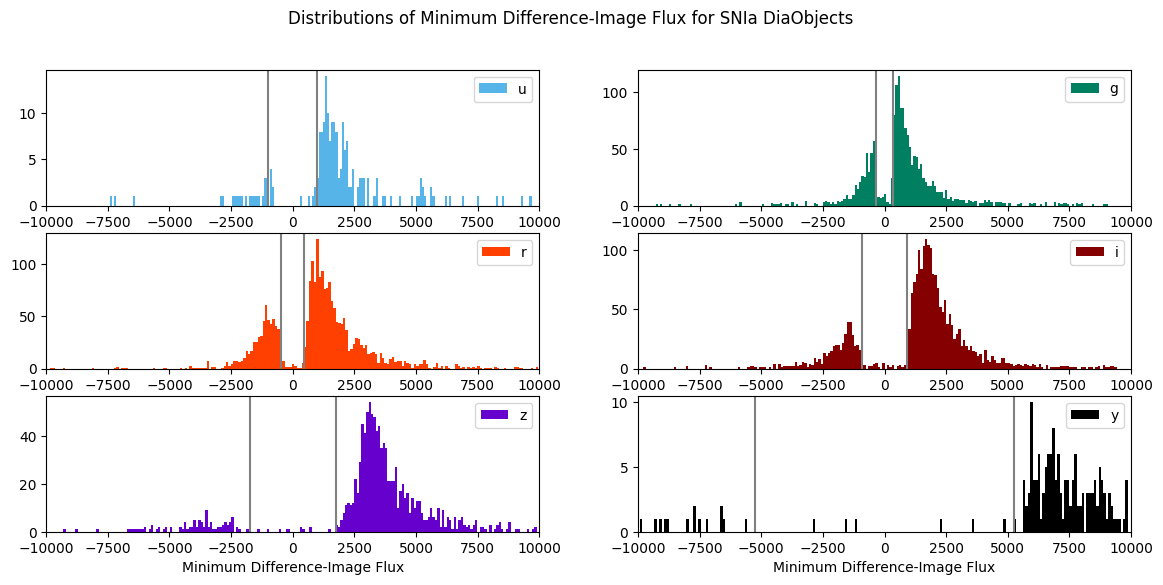

In [25]:
xmin = -10000
xmax = 10000

fig, ax = plt.subplots(3, 2, figsize=(14,6))

f = 0
for i in range(3):
    for j in range(2):
        temp = plot_filter_labels[f]+'PSFluxMin'
        filtc = plot_filter_colors[plot_filter_labels[f]]
        ttx = np.where((myTruthTable[temp][tx] > xmin) & (myTruthTable[temp][tx] < xmax))[0]
        ax[i,j].hist(myTruthTable[temp][tx[ttx]], 200, color=filtc, label=plot_filter_labels[f])
        ax[i,j].axvline(-1.0 * SNR5_PVI_nJy[f], color='grey')
        ax[i,j].axvline(SNR5_PVI_nJy[f], color='grey')
        ax[i,j].set_xlim([xmin,xmax])
        ax[i,j].set_xlabel('Minimum Difference-Image Flux')
        ax[i,j].legend(loc='upper right')
        f += 1
        del filtc, temp, ttx

plt.suptitle('Distributions of Minimum Difference-Image Flux for SNIa DiaObjects')
plt.show()

Above, it is odd that there are detections within the vertical lines. They would be SNR<5 detections. Why and how do they sneak in? A question for another time.

#### Show the fraction is ~40%

In [26]:
for f in range(6):
    temp = plot_filter_labels[f] + 'PSFluxMin'
    ttx = np.where(myTruthTable[temp][tx] < -1.0 * SNR5_PVI_nJy[f])[0]
    print('%s %4.2f' % (plot_filter_labels[f], len(ttx)/len(tx)))
    del temp, ttx

print(' ')
atx = np.where((myTruthTable['uPSFluxMin'][tx] < -1.0 * SNR5_PVI_nJy[0]) |
               (myTruthTable['gPSFluxMin'][tx] < -1.0 * SNR5_PVI_nJy[1]) |
               (myTruthTable['rPSFluxMin'][tx] < -1.0 * SNR5_PVI_nJy[2]) |
               (myTruthTable['iPSFluxMin'][tx] < -1.0 * SNR5_PVI_nJy[3]) |
               (myTruthTable['zPSFluxMin'][tx] < -1.0 * SNR5_PVI_nJy[4]) |
               (myTruthTable['yPSFluxMin'][tx] < -1.0 * SNR5_PVI_nJy[5]))[0]
print('In any filter: %4.2f' % (len(atx)/len(tx)))
del atx

u 0.01
g 0.17
r 0.26
i 0.19
z 0.05
y 0.01
 
In any filter: 0.43


It appears that **~40% of all SNIa**, which are detected as DiaObjects, suffer from template contamination in at least one filter. That fraction is high enough that everyone working on SNIa photometry needs to be aware of the issue and take measures to always correct their lightcurves for potential template contamination.

In [27]:
del tx

## 2.0 Correct for Template Contamination

Ideally we would use the forced photometry on the difference image at the location of the DiaObject for this, but as we don't have it yet, we'll have to use the detections in the DiaObject catalog.

An example correction might be, for each SNIa, to identify the date of maximum flux detected (in any filter), and then for any and all detections <300 days before and >500 days after that date, determine the mean and standard deviation of the difference-image detections in each filter.

The mean could then be the correction added to the difference-image flux, and the standard deviation can be the error imposed by this process.

### First, get all the maximum fluxes as a proxy for SN peak light

In [28]:
for f in range(6):
    temp = plot_filter_labels[f] + 'PSFluxMax'
    myTruthTable[temp] = np.zeros(len(myTruthTable), dtype='float')

In [30]:
%%time
results = service.search("SELECT diaObjectId, uPSFluxMax, gPSFluxMax, rPSFluxMax, "
                         "iPSFluxMax, zPSFluxMax, yPSFluxMax "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE diaObjectId IN "+my_list)

CPU times: user 50.7 ms, sys: 934 µs, total: 51.6 ms
Wall time: 4.73 s


In [31]:
for i in range(len(myTruthTable)):
    if myTruthTable['diaObjectId_dp02'][i] > 0:
        ix = np.where(myTruthTable['diaObjectId_dp02'][i] == results['diaObjectId'])[0]
        for f in range(6):
            temp = plot_filter_labels[f] + 'PSFluxMax'
            myTruthTable[temp][i] = results[temp][ix[0]]

In [32]:
del results

### Identify epochs <300 and >500 days pre- and post-lighcurve

Set up storage for the mean, standard deviation, and number of detections <300 days before and >500 days after the epoch of maximum flux.

In [33]:
for f in range(6):
    temp1 = plot_filter_labels[f] + '_cont_mean'
    temp2 = plot_filter_labels[f] + '_cont_sdev'
    temp3 = plot_filter_labels[f] + '_cont_N'
    myTruthTable[temp1] = np.zeros(len(myTruthTable), dtype='float')
    myTruthTable[temp2] = np.zeros(len(myTruthTable), dtype='float')
    myTruthTable[temp3] = np.zeros(len(myTruthTable), dtype='float')

Retrieve lightcurves from the DiaSource catalogs and identify epochs pre- and post-LC.

### Calculate the correction as the mean flux of pre- and post-LC epochs

Calculate the number of pre- and post-LC epochs, their mean flux, and the standard deviation in their fluxes.

In [37]:
%%time
results = service.search("SELECT diaObjectId, filterName, midPointTai, psFlux "
                         "FROM dp02_dc2_catalogs.DiaSource "
                         "WHERE diaObjectId IN "+my_list)

In [38]:
for i in range(len(myTruthTable)):
    if myTruthTable['diaObjectId_dp02'][i] > 0:
        ix = np.where(myTruthTable['diaObjectId_dp02'][i] == results['diaObjectId'])[0]
        for f in range(6):
            fx = np.where(results['filterName'][ix] == plot_filter_labels[f])[0]
            if len(fx) > 0:
                mx = np.argmax(results['psFlux'][ix[fx]])
                max_mjd = results['midPointTai'][ix[fx][mx]]
                tx = np.where((results['midPointTai'][ix[fx]] < max_mjd - 100.0) |
                              (results['midPointTai'][ix[fx]] > max_mjd + 500.0) )[0]
                myTruthTable[plot_filter_labels[f] + '_cont_N'][i] = len(tx)
                if len(tx) > 0:
                    myTruthTable[plot_filter_labels[f] + '_cont_mean'][i] = np.mean(results['psFlux'][ix[fx][tx]])
                    myTruthTable[plot_filter_labels[f] + '_cont_sdev'][i] = np.std(results['psFlux'][ix[fx][tx]])
                del mx, tx, max_mjd
            del fx

### Plot distributions of the correction values

#### Histogram: number of pre- and post-LC epochs
First plot the distribution of the number of pre- and post-LC detections that exist for the set of matched SNIa. We can see that many only have 1, which would be insufficient to estimate a correction (and they probably don't need it, anyway).

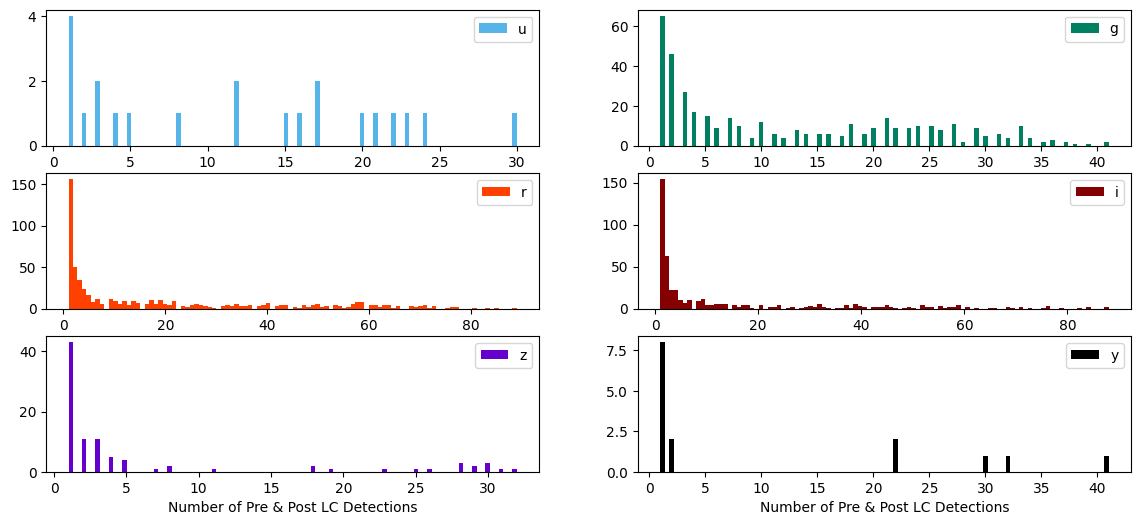

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(14,6))
f = 0
for i in range(3):
    for j in range(2):
        temp = plot_filter_labels[f]+'_cont_N'
        filtc = plot_filter_colors[plot_filter_labels[f]]
        tx = np.where(myTruthTable[temp] > 0)[0]
        ax[i,j].hist(myTruthTable[temp][tx], 100, color=filtc, label=plot_filter_labels[f])
        ax[i,j].set_xlabel('Number of Pre & Post LC Detections')
        ax[i,j].legend(loc='upper right')
        f += 1
        del filtc, temp, tx
plt.show()

#### Histogram: mean flux of the pre- and post-LC epochs

Only for SNIa with >1 pre- and post-LC epochs.

Plot the distribution of the flux values for all pre- and post-LC detections. It appears that only a tiny amount are positive, as they should be -- but not zero, which is a problem, because maybe our time range is not fully excluding epochs with SNIa light in the PVI.

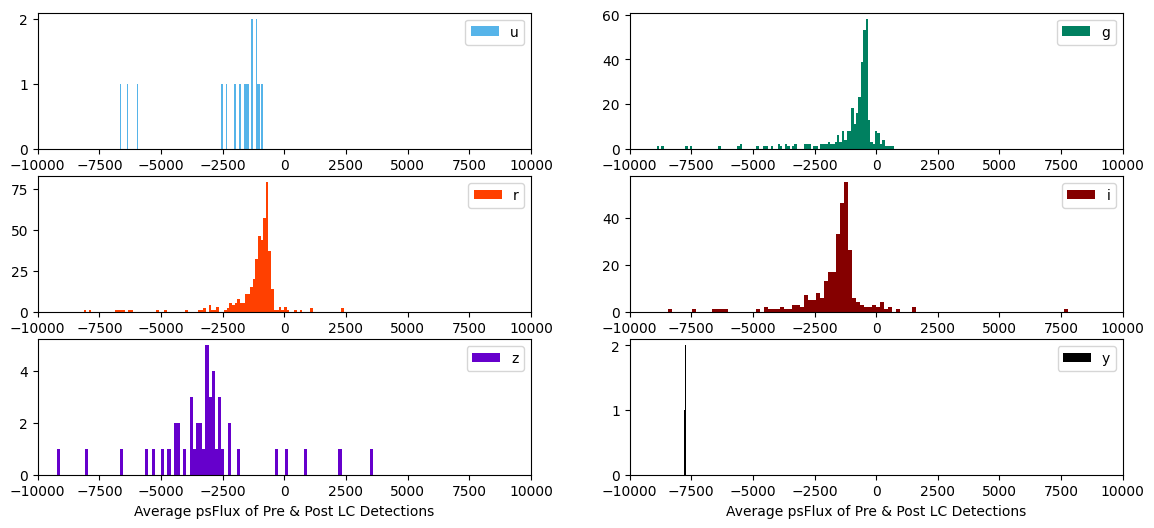

In [40]:
xmin = -10000
xmax = 10000

fig, ax = plt.subplots(3, 2, figsize=(14,6))
f = 0
for i in range(3):
    for j in range(2):
        temp1 = plot_filter_labels[f]+'_cont_mean'
        temp3 = plot_filter_labels[f]+'_cont_N'
        filtc = plot_filter_colors[plot_filter_labels[f]]
        tx = np.where((myTruthTable[temp3] > 1) & \
                      (myTruthTable[temp1] > xmin) & \
                      (myTruthTable[temp1] < xmax))[0]
        ax[i,j].hist(myTruthTable[temp1][tx], 100, color=filtc, label=plot_filter_labels[f])
        ax[i,j].set_xlabel('Average psFlux of Pre & Post LC Detections')
        ax[i,j].set_xlim([xmin,xmax])
        ax[i,j].legend(loc='upper right')
        f += 1
        del filtc, temp1, temp3, tx
plt.show()

#### Histogram: sdev in flux values for pre- and post-LC epochs

Only for SNIa with >1 pre- and post-LC epochs.

Plot the distribution of standard deviation in the flux values for all pre- and post-LC detections. 

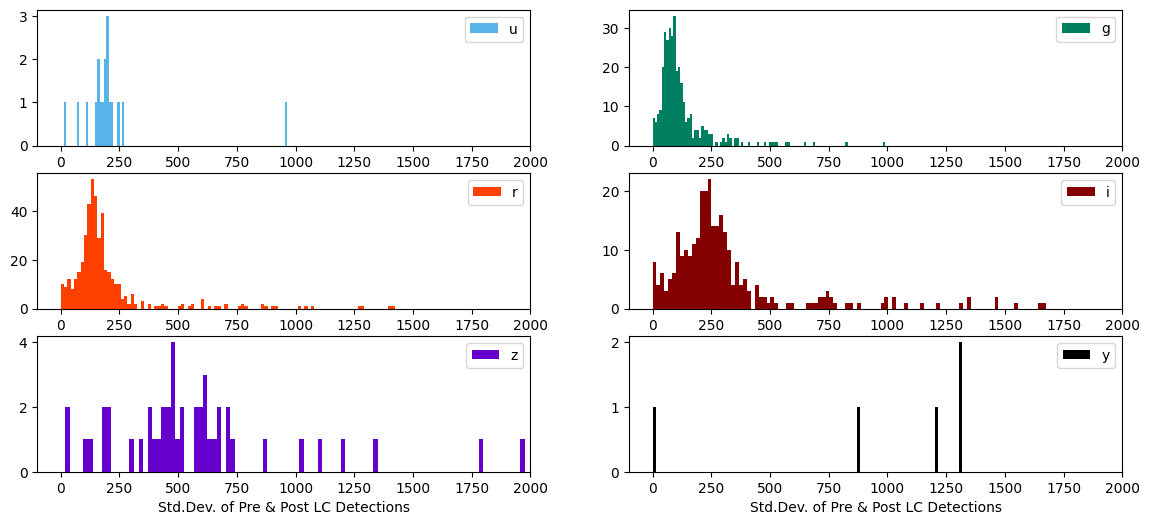

In [41]:
xmin = -100
xmax = 2000

fig, ax = plt.subplots(3, 2, figsize=(14,6))
f = 0
for i in range(3):
    for j in range(2):
        temp2 = plot_filter_labels[f]+'_cont_sdev'
        temp3 = plot_filter_labels[f]+'_cont_N'
        filtc = plot_filter_colors[plot_filter_labels[f]]
        tx = np.where((myTruthTable[temp3] > 1) & \
                     (myTruthTable[temp2] > xmin) & \
                     (myTruthTable[temp2] < xmax))[0]
        ax[i,j].hist(myTruthTable[temp2][tx], 100, color=filtc, label=plot_filter_labels[f])
        ax[i,j].set_xlim([xmin,xmax])
        ax[i,j].set_xlabel('Std.Dev. of Pre & Post LC Detections')
        ax[i,j].legend(loc='upper right')
        f += 1
        del filtc, temp2, temp3, tx
plt.show()

#### Histogram: mean/sdev flux values for pre- and post-LC epochs

Only for SNIa with >1 pre- and post-LC epochs.

More meaningful is the distribution of the standard deviation *divided by the mean* (i.e., as a fraction of the mean flux value) for all pre- and post-LC detections. 

/tmp/ipykernel_7968/2332682209.py:12: RuntimeWarning: invalid value encountered in true_divide
  value = myTruthTable[temp2]/np.abs(myTruthTable[temp1])


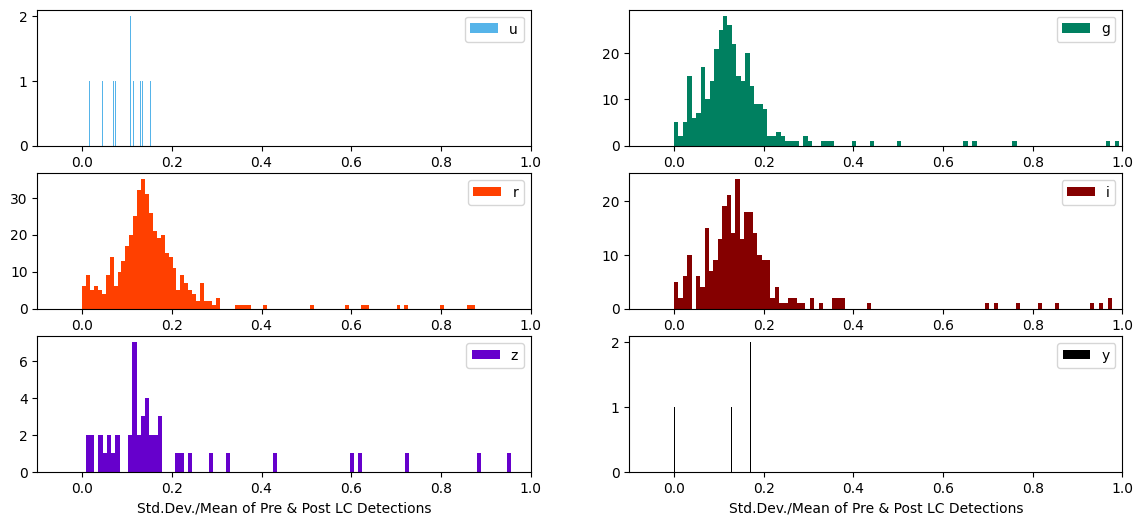

In [42]:
xmin = -0.1
xmax = 1.0

fig, ax = plt.subplots(3, 2, figsize=(14,6))
f = 0
for i in range(3):
    for j in range(2):
        temp1 = plot_filter_labels[f]+'_cont_mean'
        temp2 = plot_filter_labels[f]+'_cont_sdev'
        temp3 = plot_filter_labels[f]+'_cont_N'
        filtc = plot_filter_colors[plot_filter_labels[f]]
        value = myTruthTable[temp2]/np.abs(myTruthTable[temp1])
        
        tx = np.where((myTruthTable[temp3] > 1) & \
                     (value > xmin) & \
                     (value < xmax))[0]
        
        ax[i,j].hist(value[tx], 100, color=filtc, label=plot_filter_labels[f])
        ax[i,j].set_xlim([xmin,xmax])
        ax[i,j].set_xlabel('Std.Dev./Mean of Pre & Post LC Detections')
        ax[i,j].legend(loc='upper right')
        f += 1
        del filtc, temp2, temp3, tx
plt.show()

### The error in these correction values is 10-20%

The above plot shows that the standard deviation in the flux values for all pre- and post-LC detections is around 10-20% of the mean flux of those detections. Which shows that we can only measure template contamination with an error of about <20% using this method. 